In [1]:

import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT * FROM ebmdatalab.outlier_detection.chem_by_subpara_by_ccg_juntoaug17_limitsubpara
-- exclude non-standard CCG codes:
WHERE SUBSTR(pct,1,1) NOT BETWEEN 'A' AND 'Z' -- first character numerical
AND SUBSTR(pct,3,1) BETWEEN 'A' AND 'Z'  -- last character alphabetical
'''

df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=False)

## Clean the data: sort out null denominators

In [2]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all ccgs
b = df1[["pct"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - need to list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","subpara","denom"]].groupby(["subpara","pct"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)
data2

,pct,subpara,denom_subpara,chemical,num,denom,ratio
0,10C,1202030,203.0,1202030R0,35.0,203.0,0.172414
1,10C,1202030,203.0,1202030S0,166.0,203.0,0.817734
2,10C,1202030,203.0,120203000,2.0,203.0,0.009852
3,10C,1203010,180.0,1203010C0,0.0,0.0,0.000000
4,10C,1203010,180.0,1203010E0,137.0,180.0,0.761111
5,10C,1203010,180.0,1203010K0,4.0,180.0,0.022222
6,10C,1203010,180.0,1203010M0,39.0,180.0,0.216667
7,10C,1203010,180.0,1203010Q0,0.0,0.0,0.000000
8,10C,1203010,180.0,1203010F0,0.0,0.0,0.000000
9,10C,1203010,180.0,1203010U0,0.0,0.0,0.000000


### Calculate key stats

In [3]:
#select columns of interest and get key stats
df2 = data2[["chemical","subpara", "ratio"]].groupby(["chemical","subpara"]).describe()
df2 = df2.unstack()
df2.columns = df2.columns.droplevel()
df2 = df2.reset_index()

#limit to chemicals prescribed by at least 10 CCGs??
df3 = df2#.loc[df2["count"]>9].reset_index()
df3["range"] = df3["max"] - df3["min"]
df3 = df3[["chemical","subpara","count","50%","min","max","range","std"]].rename(columns={"50%":"median"})

df3.head() #.loc[df3["range"]<0.1]

,chemical,subpara,count,median,min,max,range,std
0,0101010C0,0101010,192.0,0.013179,0.000000,0.340426,0.340426,0.069412
1,0101010F0,0101010,192.0,0.000000,0.000000,0.185629,0.185629,0.017496
2,0101010G0,0101010,192.0,0.440633,0.081081,0.912442,0.831361,0.186258
3,0101010I0,0101010,192.0,0.016001,0.000000,0.294872,0.294872,0.049069
4,0101010J0,0101010,192.0,0.018857,0.000000,0.162162,0.162162,0.027994


### Calculate Kurtosis/Skew 
Need to import stats module and reshape data

In [5]:
# reshape data to put CCGs in columns
df5 = data2.pivot(index="chemical",columns='pct', values='ratio')

#sum numerators to find total volume for each chemical
num = pd.DataFrame(df1["num"].groupby(df1["chemical"]).sum()).reset_index()

#calculate kurtosis and skew for each chemical
import scipy.stats as stats
k = pd.Series(stats.kurtosis(df5, axis=1,nan_policy="omit"),name="kurtosis")
sk =  pd.Series(stats.skew(df5, axis=1,nan_policy="omit"),name="skew")

num["num centile"] = pd.qcut(num["num"], 10, labels=np.arange(1,11,1))
num.head()

,chemical,num,num centile
0,0101010C0,1423,5
1,0101010F0,119,3
2,0101010G0,19759,7
3,0101010I0,1050,4
4,0101010J0,984,4


### Compile stats up

In [6]:

result = pd.concat([df3, k, sk], axis=1).sort_values(by="kurtosis",ascending=False)
result = result.merge(num, on="chemical")
#result[["chemical","subpara","num","count","median","abs_min","min","max","range","abs_range", "std","std_inc_zeros","kurtosis","skew"]].round(2)
result = result[["chemical","subpara","num","num centile", "count","median","min","max","range","std","kurtosis","skew"]].round(2)

# Lookup chemical and subparagraph names
df4 = result.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
df4 = df4.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
#df3 = df3[["chemical","chemical name","subpara","subpara name","min","max","range","std"]]
df4 = df4[["chemical","chemical name","subpara","subpara name","num","num centile", "count","median","min","max","range", "std","kurtosis","skew"]].round(2)
df4.head()

C:\Users\hcurtis\Anaconda2\lib\site-packages\pandas\core\series.py:1342: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


,chemical,chemical name,subpara,subpara name,num,num centile,count,median,min,max,range,std,kurtosis,skew
0,0501012G0,Flucloxacillin Sodium,0501012,Penicillinase-Resistant Penicillins,1058061,10,207.0,1.0,1.0,1.00,0.00,0.0,202.0,-14.28
1,0304010F0,Brompheniramine Maleate,0304010,Antihistamines,8,1,207.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28
2,020400010,Pindolol With Diuretic,0204000,Beta-Adrenoceptor Blocking Drugs,1,1,207.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28
3,1001030A0,Auranofin,1001030,Rheumatic Disease Suppressant Drugs,1,1,207.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28
4,120203000,Other Nasal Infection Preps,1202030,Nasal Prepn for Infection,2,1,207.0,0.0,0.0,0.01,0.01,0.0,202.0,14.28


## Ranking Chemicals by Range, Kurtosis, Skew and SD

In [7]:
# sort by range first
r1 = df4.loc[(df4["num centile"]>2)].sort_values(by=["range","kurtosis"],ascending=False).head(20)
# create a flag
r1["R"] = 1

# sort by kurtosis and limit to items with at least 1% range 
r2 = df4.loc[(df4["range"] >0.1) & (df4["num centile"]>2)].sort_values(by=["kurtosis"],ascending=False).head(20)
r2["K"] = 1

# sort by skew
r3 = df4.loc[(df4["range"] >0.1) & (df4["num centile"]>2)].sort_values(by=["skew"],ascending=False).head(20)
r3["Sk"] = 1

#sort by SD
r4 = df4.loc[(df4["range"] >0.1) & (df4["num centile"]>2)].sort_values(by=["std"],ascending=False).head(20)
r4["SD"] = 1
r4

,chemical,chemical name,subpara,subpara name,num,num centile,count,median,min,max,range,std,kurtosis,skew,SD
1465,0401030E0,Amobarbital Sodium,0401030,Barbiturates,69,3,2.0,0.52,0.05,1.00,0.95,0.67,-2.00,0.00,1
1459,0503010Q0,Lamivudine,0503010,HIV Infection,171,3,3.0,0.88,0.18,0.92,0.74,0.42,-1.50,-0.70,1
1444,0501090K0,Isoniazid,0501090,Antituberculosis Drugs,5079,6,65.0,0.19,0.00,0.97,0.97,0.36,-1.27,0.67,1
1461,0208010D0,Enoxaparin,0208010,Parenteral Anticoagulants,44906,8,204.0,0.34,0.00,1.00,0.99,0.36,-1.62,0.23,1
1224,1501030G0,Glycopyrronium Bromide,1501030,Antimuscarinic Drugs,14241,7,108.0,0.96,0.00,1.00,1.00,0.34,0.17,-1.34,1
1223,1501030H0,Hyoscine Hydrobromide,1501030,Antimuscarinic Drugs,5035,6,108.0,0.03,0.00,1.00,1.00,0.34,0.17,1.35,1
1438,0208010L0,Dalteparin Sodium,0208010,Parenteral Anticoagulants,33908,8,204.0,0.16,0.00,0.98,0.98,0.33,-1.18,0.66,1
1388,0106050S0,Sodium Picosulfate,0106050,Bowel Cleansing Preparations,249,3,7.0,0.68,0.07,0.96,0.89,0.30,-0.52,-0.75,1
1409,0106050B0,Bowel Cleansing Solutions,0106050,Bowel Cleansing Preparations,175,3,7.0,0.31,0.04,0.89,0.85,0.29,-0.66,0.77,1
1450,0501040H0,Gentamicin Sulfate,0501040,Aminoglycosides,223,3,3.0,0.95,0.45,0.97,0.52,0.29,-1.50,-0.70,1


### Results compiled

In [8]:
# compile top 20 from each sort into a single output

rc = pd.merge(r1, r2, on=["chemical","chemical name","subpara","subpara name","num","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
rc = rc.merge(r3, on=["chemical","chemical name","subpara","subpara name","num","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
rc = rc.merge(r4, on=["chemical","chemical name","subpara","subpara name","num","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer").fillna(0)  

rc["score"] = rc["R"]+rc["K"]+rc["Sk"]+rc["SD"]
rc.sort_values(by=["score","range","kurtosis"],ascending=False)

,chemical,chemical name,subpara,subpara name,num,num centile,count,median,min,max,range,std,kurtosis,skew,R,K,Sk,SD,score
0,1301010I0,Wool Fat Hydrous,1301010,Vehicles,251,3,28.0,0.00,0.00,1.00,1.00,0.27,4.59,2.40,1.0,0.0,0.0,1.0,2.0
1,1301010D0,Cetomacrogol,1301010,Vehicles,23006,7,28.0,1.00,0.00,1.00,1.00,0.27,4.53,-2.39,1.0,0.0,0.0,1.0,2.0
2,1501030H0,Hyoscine Hydrobromide,1501030,Antimuscarinic Drugs,5035,6,108.0,0.03,0.00,1.00,1.00,0.34,0.17,1.35,1.0,0.0,0.0,1.0,2.0
3,1501030G0,Glycopyrronium Bromide,1501030,Antimuscarinic Drugs,14241,7,108.0,0.96,0.00,1.00,1.00,0.34,0.17,-1.34,1.0,0.0,0.0,1.0,2.0
4,0208010D0,Enoxaparin,0208010,Parenteral Anticoagulants,44906,8,204.0,0.34,0.00,1.00,0.99,0.36,-1.62,0.23,1.0,0.0,0.0,1.0,2.0
5,0208010W0,Tinzaparin Sodium,0208010,Parenteral Anticoagulants,17389,7,204.0,0.04,0.00,0.98,0.98,0.28,0.91,1.54,1.0,0.0,0.0,1.0,2.0
6,0208010L0,Dalteparin Sodium,0208010,Parenteral Anticoagulants,33908,8,204.0,0.16,0.00,0.98,0.98,0.33,-1.18,0.66,1.0,0.0,0.0,1.0,2.0
7,0501090K0,Isoniazid,0501090,Antituberculosis Drugs,5079,6,65.0,0.19,0.00,0.97,0.97,0.36,-1.27,0.67,1.0,0.0,0.0,1.0,2.0
11,0401030E0,Amobarbital Sodium,0401030,Barbiturates,69,3,2.0,0.52,0.05,1.00,0.95,0.67,-2.00,0.00,1.0,0.0,0.0,1.0,2.0
17,0106050S0,Sodium Picosulfate,0106050,Bowel Cleansing Preparations,249,3,7.0,0.68,0.07,0.96,0.89,0.30,-0.52,-0.75,1.0,0.0,0.0,1.0,2.0


## Paragraph Rankings
Which paragraphs occur most often in the list of interesting chemicals?

In [9]:
para = rc.groupby(["subpara","subpara name"])["score"].agg(["count","sum"]).sort_values(by=["count","sum"],ascending=False)
para.loc[para["count"]>1]

,,count,sum
subpara,subpara name,,
0208010,Parenteral Anticoagulants,3,6.0
0905022,Phosphate Binding Agents,3,3.0
0402010,Antipsychotic Drugs,2,4.0
0501090,Antituberculosis Drugs,2,4.0
1301010,Vehicles,2,4.0
1501030,Antimuscarinic Drugs,2,4.0
0106050,Bowel Cleansing Preparations,2,3.0
0501070,Some Other Antibacterials,2,3.0
0902011,Oral Potassium,2,3.0


## CCG Rankings
### All chemicals

In [10]:
dftest = data2#.head(1000)
dftest
#df5 = pd.qcut(series, 10, labels=np.arange(1,11,1))
dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
#dftest.groupby(["pct"])["ratio"].sum()
#dftest.loc[dftest["chemical"]=="0101010C0"].sort_values(by=["chemical","rank"])

x = dftest.loc[(dftest["rank"]<=0.05) | (dftest["rank"]>=0.95)]
x2 = x.groupby("pct")["rank"].count()
x2.sort_values(ascending=False)

pct
02W    263
03V    202
08V    190
99C    182
10T    182
03Y    177
07T    168
00N    164
03X    164
03H    161
08M    160
07G    160
13T    153
06D    151
00L    148
04M    148
00P    147
10L    147
02R    146
06M    146
08C    145
07R    143
04C    142
03M    142
00R    141
08H    140
08Y    140
09A    140
06W    139
10W    139
      ... 
09L     73
07N     73
05A     73
99A     72
10V     72
08G     70
05J     70
05R     70
01R     69
01K     69
14L     69
08A     68
11X     68
04V     66
05Q     65
01A     62
05N     62
99P     61
11J     60
99J     60
06F     59
13P     58
06H     58
99N     56
09G     56
07H     55
09Y     54
06K     54
99H     51
06N     50
Name: rank, dtype: int64

### Ranking CCGs for the list of interesting chems only, by Distance from Median

In [11]:
dftest = rc[["chemical","chemical name","subpara name","min","max","range","median"]].merge(data2, on="chemical")
#dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
dftest["abs diff"] = abs(dftest["ratio"]-dftest["median"])/dftest["range"]
dftest["rank abs diff"] = dftest.groupby(["chemical"])["abs diff"].rank(pct=True)
dftest.sort_values(by=["chemical","rank abs diff"])

#x0 = dftest.loc[(dftest["rank abs diff"]<=0.05)]# & (dftest["median"]>0)]
x1 = dftest.loc[(dftest["rank abs diff"]>=0.95)]# & (dftest["median"]<1)] 
x2 = x1#x0.append(x1)
x2 = x2.groupby("pct")["abs diff"].agg(["count","mean"])
x2.sort_values(by=["count","mean"],ascending=False).head(12)



,count,mean
pct,,
02R,8,0.594029
07L,7,0.348686
00T,6,0.559136
06M,6,0.543001
11N,6,0.473623
08E,6,0.425479
03G,5,0.775550
03C,5,0.775198
05C,5,0.699350


### Investigate example CCG

In [12]:
x3 = x1[["pct","chemical"]].merge(dftest, how="inner", on=["pct","chemical"]).drop(["subpara","denom","range"], axis=1)
x3.loc[x3["pct"]=="02R"].sort_values(by=["rank abs diff","abs diff"],ascending=False)

,pct,chemical,chemical name,subpara name,min,max,median,denom_subpara,num,ratio,rank,abs diff,rank abs diff
374,02R,0911010T0,Taurine,Amino Acids & Nutritional Agents,0.00,0.77,0.00,56.0,43.0,0.767857,1.000000,0.997217,1.000000
376,02R,091101000,Other Amino Acid&Nutritional Agent Preps,Amino Acids & Nutritional Agents,0.23,1.00,1.00,56.0,13.0,0.232143,0.066667,0.997217,1.000000
259,02R,1305020R0,Tacalcitol,Preparations For Psoriasis,0.00,0.12,0.00,1678.0,193.0,0.115018,1.000000,0.958482,1.000000
301,02R,1105000S0,Tropicamide,Mydriatics And Cycloplegics,0.00,0.39,0.01,141.0,23.0,0.163121,0.987500,0.392617,0.987500
112,02R,0906060Q0,Phytomenadione,Vitamin K,0.00,0.90,0.27,129.0,105.0,0.813953,0.979592,0.604393,0.979592
115,02R,0906060L0,Menadiol Sodium Phosphate,Vitamin K,0.10,1.00,0.73,129.0,24.0,0.186047,0.040816,0.604393,0.979592
157,02R,090602700,Other Vitamin B Compound Preps,Vitamin B Compound,0.00,0.17,0.00,535.0,9.0,0.016822,0.975845,0.098955,0.975845
146,02R,0906027G0,Vitamin B Compound,Vitamin B Compound,0.83,1.00,1.00,535.0,526.0,0.983178,0.028986,0.098955,0.975845


### Histograms

In [13]:
## reshape dataset to use Seaborn FacetGrid/DistPlot.

## exclude practice IDs etc and select only lists of figures to plot:
dfh = rc[["chemical","chemical name","subpara name"]].merge(data2[["chemical","ratio"]], on="chemical").drop("chemical",axis=1).sort_values(by="chemical name")

# create list of titles for charts - combine chem name with no of CCGs
titles = dfh.groupby(["chemical name","subpara name"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+"\n"+" ("+titles["subpara name"].str[0:25]+", n="+titles["n"].map(str) +")"
titles = titles["title"]
titles

0              Amobarbital Sodium\n (Barbiturates, n=2)
1     Ascorbic Acid\n (Vitamin C (Ascorbic Acid), n=...
2     Benzalkonium Chloride\n (Barrier Preparations,...
3     Bowel Cleansing Solutions\n (Bowel Cleansing P...
4     Calcium Acetate\n (Phosphate Binding Agents, n...
5     Calcium Polystyrene Sulfonate\n (Oral Potassiu...
6                  Cefadroxil\n (Cephalosporins, n=207)
7                       Cetomacrogol\n (Vehicles, n=28)
8     Dalteparin Sodium\n (Parenteral Anticoagulants...
9     Darbepoetin Alfa\n (Hypoplastic/Haemolytic & ,...
10    Dimeticone (Barrier)\n (Barrier Preparations, ...
11      Enoxaparin\n (Parenteral Anticoagulants, n=204)
12          Gentamicin Sulfate\n (Aminoglycosides, n=3)
13           Glucose\n (Foods For Special Diets, n=207)
14    Glycopyrronium Bromide\n (Antimuscarinic Drugs...
15    Hydrogen Peroxide\n (Prep's For Minor Cuts & A...
16    Hyoscine Hydrobromide\n (Antimuscarinic Drugs,...
17           Isoniazid\n (Antituberculosis Drugs

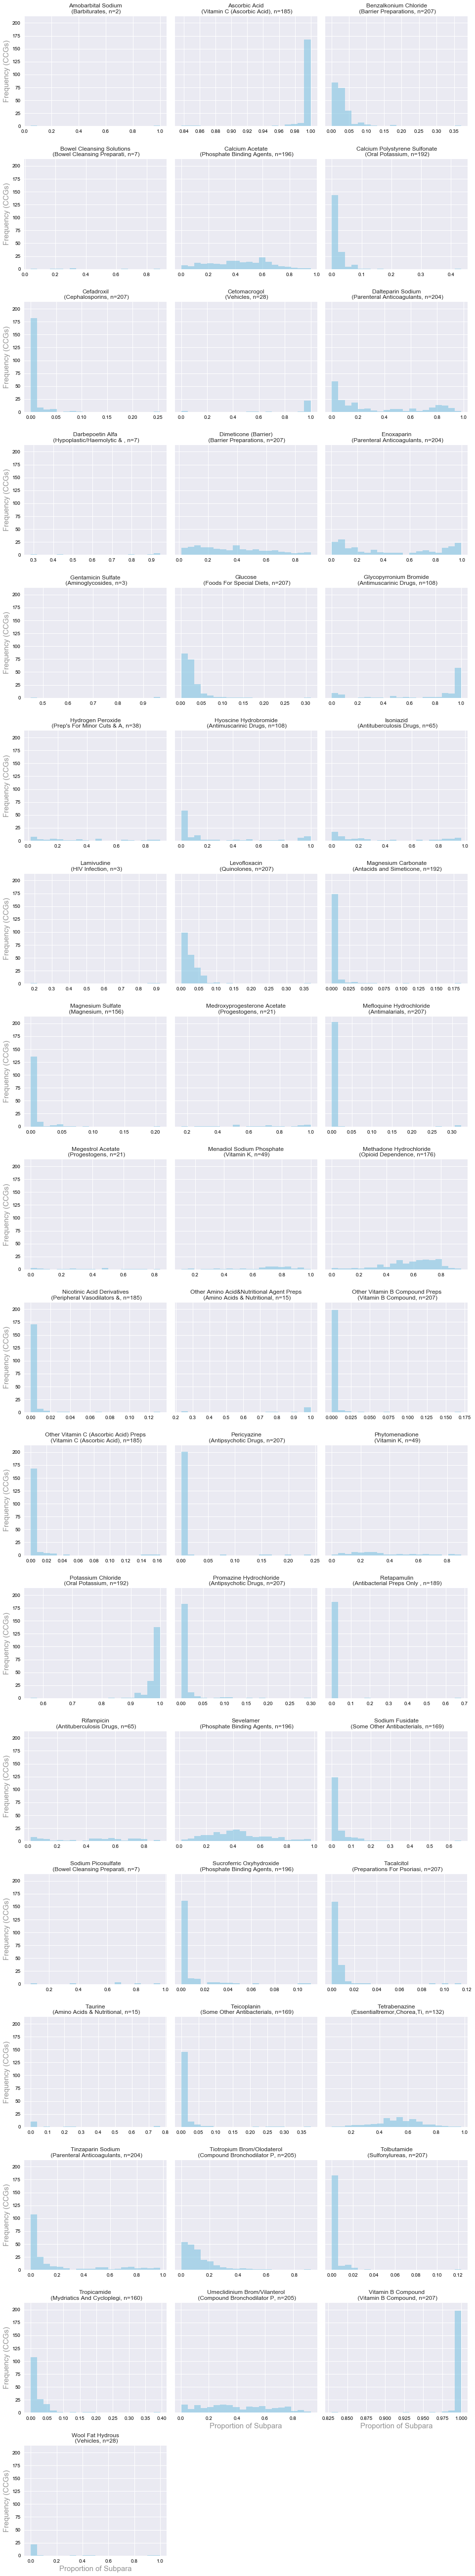

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
#("\n".join(wrap(, 16))) <<<<< may be good way to wrap titles

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#titles = dfh["chemical name"].drop_duplicates() # create a list of integers, one for each subplot
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 20)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
#sns.plt.title('YOUR TITLE HERE')

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Hyperlinks

In [17]:
dfhy = rc[["chemical","subpara"]].merge(data2[["chemical","ratio"]], on="chemical")#.drop("chemical",axis=1)
links = dfhy.groupby(["chemical","subpara"]).count().reset_index().rename(columns={"ratio":"n"})
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"

#https://openprescribing.net/analyse/#org=CCG&numIds=100302010&denomIds=10.3.2&selectedTab=map
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

#links["clickable"] = 
pd.DataFrame(links["link"]).style.format(make_clickable)
#links[["chemical","subpara","link"]]

- charts x
- better ccg ranking x
- create table of links x
- change the query so it only limits by subpara >n rather than chemical x
- practice level
- better chemical ranking (logs?)
